In [1]:
from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

import pandas as pd
import numpy as np

from IPython.display import display, Markdown

import locale
_ = locale.setlocale(locale.LC_ALL, "it_IT")

# I tassi di riproduzione: $\Re_0$ e $\Re_t$

## Il modello **SIRD**

I processi di diffusione delle epidemie sono notevolmente complessi e dipendono da numerosi fattori. È tuttavia possibile, grazie all'utilizzo di specifici modelli matematici, stimare l'andamento di un'epidemia al fine di valutarne l'evoluzione naturale e/o l'efficacia delle contromisure di contenimento (distaziamento sociale, lockdown, ecc).

I modelli più spesso utilizzati sono di tipo compartimentale <cite data-cite="fassina2013modelli"></cite>: la popolazione viene suddivisa in _compartimenti_ e il passaggio dei soggetti da un compartimento all'altro è definito da regole probabilistiche notevolmente semplificate.

Uno dei modelli compartimentali più usati per le malattie infettive è il **SIRD** <cite data-cite="ep_repository_2020"></cite>. La popolazione è suddivisa in:

- **S**: Suscettibili. Tutti coloro che non hanno contratto la malattia e potrebbero essere contagiati.

- **I**: Infetti. Coloro che hanno contratto la malattia, non sono guariti e potrebbero contagiare uno o più Suscettibili.

- **R**: Guariti (dall'inglese _Recovered_). I soggetti che hanno contratto la malattia e ne sono guariti.

- **D**: Deceduti. Tutti coloro che sono deceduti a causa della malattia specifica contratta in precedenza.

Le _regole di transizione_ descrivono la possibilità di passaggio dei soggetti da un compartimento all'altro $\ref{fig:sird}$ (in alcuni modelli più semplici, $\mathbf{R}$ e $\mathbf{D}$ sono 'uniti' in un unico comparto $\mathbf{R}$, Rimossi, e il passaggio da Infetti a Rimossi è regolato dal tasso di rimozione, modello ***SIR***).

![SIRD](images/sird.png)

Il passaggio da Suscettibili $\mathbf{S}$ a Infetti $\mathbf{I}$ è determinato dal parametro di transizione $\beta$ (da cui dipende direttamente il tasso di trasmissione della malattia). Un soggetto infettato non può "rientrare" nei Suscettibili dato che, una volta contratta la malattia, si suppone che svilupperà anticorpi e dunque non potrà essere infettato nuovamente.

Il passaggio da Infetti $\mathbf{I}$ a Guariti $\mathbf{R}$ è regolato dal tasso di guarigione $\alpha$. Anche in questo caso, si suppone che il soggetto non possa essere reinfettato e che un eventuale decesso sia da attribuire a cause differenti dalla malattia in esame.

Il passaggio da Infetti $\mathbf{I}$ a Deceduti $\mathbf{D}$ è invece descritto dal tasso di letalità $\delta$.

La quantità di soggetti presenti in ogni compartimento è, come si può facilmente dedurre, variabile nel tempo $t$.

Dunque parleremo di $\mathbf{S}_t$, $\mathbf{I}_t$, $\mathbf{R}_t$ e $\mathbf{D}_t$ rispettivamente per Suscettibii, Infetti, Guariti e Deceduti nel tempo $t$.

In assenza di malattia, $\mathbf{S}$ sarà pari all'intera popolazione, che chiameremo $\mathbf{N}$, mentre gli altri compartimenti saranno vuoti.

Possiamo immaginare quindi l'inizio di una possibile epidemia generata nel momento iniziale $t=0$ da un singolo individuo Infetto ($\mathbf{I}_0 = 1$) il quale può contagiare un certo numero di Suscettibili.

Man mano che l'epidemia avanza ($t_0 + \Delta t_1$ nella figura $\ref{fig:transird}$), il numero di Infetti aumenterà e diminuirà il numero dei Suscettibili.

Successivamente ($t_0 + \Delta t_2$ nella figura $\ref{fig:transird}$), alcuni soggetti inizieranno a guarire e per altri il decorso risulterà fatale.

In questo caso ci riferiamo ad un $\Delta$ temporale arbitrario. Solitamente, nel corso di un'epidemia, i dati raccolti hanno cadenza giornaliera. Dunque quando si parla di $\Delta$ ci si riferisce (laddove non altrimenti specificato) alla differenza giornaliera dei dati.

In [2]:
def sird(ax, s, i, r, d, time=""):
    ax.scatter(
        0, 0, facecolors="none",
        edgecolor="k",
        s=10000
    )
    ax.scatter(
        0, 0, c="k",
        alpha=.25,
        s=s
    )
    ax.arrow(.8, 0, .4, 0, head_width=.1, length_includes_head=True, color="b")
    ax.text(-1.1, 0, "$\mathbf{S}$", fontsize="xx-large")

    ax.scatter(
        2, 0, facecolors="none",
        edgecolor="b",
        s=10000
    )
    ax.scatter(
        2, 0, c="b",
        alpha=.25,
        s=i
    )
    ax.arrow(2.7, .3, .56, .4, head_width=.1, length_includes_head=True, color="g")
    ax.arrow(2.7, -.3, .56, -.4, head_width=.1, length_includes_head=True, color="r")
    ax.text(2.9, 0, "$\mathbf{I}$", fontsize="xx-large")

    ax.scatter(
        4, 1, facecolors="none",
        edgecolor="g",
        lw=1,
        s=10000
    )
    plt.scatter(
        4, 1, c="g",
        alpha=.25,
        s=r
    )
    ax.text(4.9, 1, "$\mathbf{R}$", fontsize="xx-large")
    
    ax.scatter(
        4, -1, facecolors="none",
        edgecolor="r",
        lw=1,
        s=10000
    )
    plt.scatter(
        4, -1, c="r",
        alpha=.25,
        s=d
    )
    ax.text(4.9, -1, "$\mathbf{D}$", fontsize="xx-large")
    
    ax.set_xlim(-1, 5)
    ax.set_ylim(-2, 2)
    ax.set_title(f"SIRD in {time}")
    ax.axis("off")

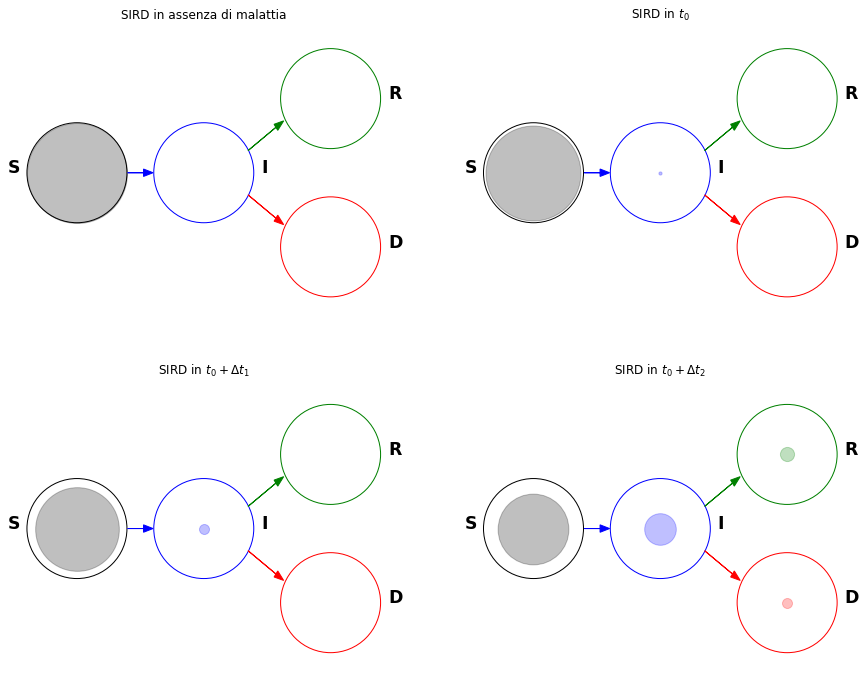

In [3]:
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
sird(axs.flat[0], 10000, 0, 0, 0, time="assenza di malattia")
sird(axs.flat[1], 9000, 10, 0, 0, time="$t_0$")
sird(axs.flat[2], 7000, 100, 0, 0, time="$t_0 + \Delta t_1$")
sird(axs.flat[3], 5000, 1000, 200, 100, time="$t_0 + \Delta t_2$")
plt.show()

## Il tasso netto di riproduzione $\Re_0$

Il numero medio di contagi generati dal primo Infetto in $t=0$ è chiamato appunto _tasso netto di riproduzione_ o _numero di riproduzione di base_ $\Re_0$ <cite data-cite="jones_2007"></cite>.

Nella figura $\ref{fig:r0ex}$ dunque, il tasso di riproduzione di base sarà $\Re_0 = 3$, ovvero: il primo individuo infetto ne può contagiare in media 3, ciascuno di loro ne potrà contagiare altri 3, eccetera.

Quindi al tempo $t=1$, gli Infetti saranno quattro, $\mathbf{I}_1 = 4$ e i Suscettibili saranno l'intera popolazione meno i quattro individui Infetti ovvero $\mathbf{S}_1 = \mathbf{N} - \mathbf{I}_1 = \mathbf{N} - 4$.

Al tempo $t=2$, gli Infetti saranno già tredici, $\mathbf{I}_2 = 13$ e i Suscettibili saranno l'intera popolazione meno i tredici soggetti Infetti ovvero $\mathbf{S}_2 = \mathbf{N} - \mathbf{I}_2 = \mathbf{N} - 13$

Più elevato è il numero di riproduzione di base $\Re_0$ più velocemente si propagherà un'epidemia.

Per ciascuna malattia infettiva, viene calcolato (e ricalcolato) un tasso di riproduzione di base medio che diventa dunque un indice del grado di contagiosità della malattia, utile per comparare tra di loro differenti patologie ed eventuali modifiche del grado di contagiosità di una malattia in tempi e/o luoghi differenti.

Concludendo la linea temporale, al termine dell'epidemia nel tempo $t_{\omega}$, il compartimento degli Infetti sarà nuovamente vuoto ma avremo una certa quantità di Guariti e Deceduti e la popolazione Suscettibile (in caso di una nuova epidemia della stessa malattia) sarà dunque ridotta a $\mathbf{S}_{\omega} = \mathbf{N} - (\mathbf{R}_{\omega} + \mathbf{D}_{\omega})$.

![R0](images/r0.png)

Fin qui abbiamo però considerato il tasso di riproduzione come una quantità costante.

È però intuibile che durante un'epidemia il passaggio dei soggetti da un compartimento all'altro non sia costante ma si modifichi nel tempo. Ad esempio:

- le contromisure di distanziamento sociale e i lockdown possono (e sono volti propriamente a) diminuire il più possibile il tasso di trasmissione $\beta$

- nuove cure, farmaci o vaccini possono influire positivamente sia sul tasso di guarigione $\alpha$ che sul tasso di letalità $\delta$.

Queste variazioni nel tempo dei tassi di transizione possono a loro volta influire sulla quantità di soggetti mediamente infettati e dunque su $\Re_0$ <cite data-cite="department_of_health"></cite> <cite data-cite="ceps_pubblication"></cite> <cite data-cite="kissler_tedijanto_lipsitch_grad_2020"></cite>.

Dal punto di vista matematico infatti, $\Re_0$ dipende dai tre tassi di transizione (dove $\Delta$ si riferisce in questo caso alle variazioni giornaliere dei compartimenti):

$$ \Re_0 = \frac{ \Delta\mathbf{I} + (\Delta\mathbf{R} + \Delta\mathbf{D})}{ \Delta\mathbf{R} + \Delta\mathbf{D} } = \frac{ \beta \; \mathbf{I}_0 \; \mathbf{S}_0 }{ \alpha \; \mathbf{I}_0 + \delta \; \mathbf{I}_0} $$

ma dato che, come abbiamo visto precedentemente, all'istante iniziale $t=0$ il compartimento degli Infetti contiene un solo soggetto $\mathbf{I}_0 = 1$

$$ \Re_0 = \frac{ \beta \; \mathbf{S}_0 }{ \alpha + \delta } $$

Visto in quest'ottica, $\Re_0$ perde il significato di numero di riproduzione di base ma diventa un utile indice di diffusione dell'epidemia: non più quindi la quantità di contagi generati da un'individuo infetto al tempo iniziale $t_0$ bensì il rapporto variabile nel tempo tra il tasso di trasmissione e i tassi di rimozione, ovvero tra la variazione giornaliera di nuovi Infetti e nuovi Gauriti o Deceduti.

Se il numero di riproduzione di base nel tempo resta maggiore di 1 ($\Re_0 > 1$) significa che il numero di nuovi Infetti è maggiore del numero giornaliero di Guariti o Deceduti e dunque l'epidemia continuerà ad alimentarsi. Quando invece scende al di sotto dell'unità ($\Re_0 < 1$) l'epidemia è sotto controllo e tenderà ad estinguersi (più o meno velocemente) perché il numero giornaliero di nuovi Guariti o Deceduti è maggiore del numero di nuovi Infetti.

## Il tasso di riproduzione effettivo $\Re_t$

Analizzando popolazioni di ridotte dimensioni, è possibile anche affidarsi al calcolo del _tasso di riproduzione effettivo_ $\Re_t$ per una valutazione a medio/lungo termine di un'epidemia <cite data-cite="k-sys"></cite> <cite data-cite="bettencourt_ribeiro_2008"></cite>.

$$ \Re_t = \Re_0 \frac{\mathbf{S}_t}{\mathbf{S}_0} $$

L'utilità di $\Re_t$ è che può variare nel tempo anche in caso di un $\Re_0$ costante, ovvero anche nel caso in cui le contromisure di contenimento non siano efficaci o non siano state applicate e/o nessuna nuova cura migliori il tasso di guarigione o influisca sul tasso di mortalità. È anche dunque un parametro utile per valutare il corso naturale di un'epidemia in assenza di interventi contenitivi o medici.

## Calcoli ed esempi: Italia

Mostreremo di seguito alcuni semplici esempi di calcolo di $\Re_0$ ed $\Re_t$ basati sui dati italiani pubblicati dal Dipartimento di Protezione Civile <cite data-cite="pcm_dpc_2020"></cite>.

### $\Re_0$ "statico"

La stima di $\Re_0$ "statico" è notevelomente complessa e dipende da numerosi fattori, tra cui i più importanti

- la scelta accurata del tempo iniziale $t_0$

- le caratteristiche demografiche della popolazione esaminata

- le vie e la dinamica di trasmissione del contagio

- il tracciamento dei contatti

- l'età e il sesso della popolazione considerata

tutti questi parametri possono influire sul numero di riproduzione di base caratteristico della malattia in esame <cite data-cite="delamater_street_leslie_yang_jacobsen_2019"></cite> <cite data-cite="report_2020"></cite>.

Per COVID-19, l'Organizzazione Mondiale della Sanità e numerosi altri centri di ricerca nel mondo hanno pubbliato stime di $\Re_0$ che sono comprese tra $1.4$ e $5.7$ <cite data-cite="report_2020"></cite>. Per avere un termine di paragone, ad esempio, la varicella ha un numero di riproduzione di base di $10$-$12$ e l'influenza stagionale di $0.9$-$2.1$ <cite data-cite="wikipedia_2020"></cite>. Dunque COVID-19 ha un $\Re_0$ piuttosto elevato.

### $\Re_0$ "dinamico"

$\Re_0$ "dinamico" può essere calcolato con diversi metodi e diversi modelli matematici. Utilizzando il modello **SIRD**, il calcolo più semplice possibile si riduce al rapporto tra la variazione giornaliera di nuovi Infetti e la variazione di nuovi Guariti e Deceduti <cite data-cite="ep_repository_2020"></cite>:

$$ \Re_0 = \frac{ \Delta\mathbf{I} }{ \Delta\mathbf{R} + \Delta\mathbf{D} } + 1 $$

vediamo un esempio di applicazione di questa formula semplificata sui casi di COVID-19 in Italia, "smussando" il più possibile la variabilità dei dati giornalieri dovuta a errori, correzioni, numero di tamponi effettuati e comunicazione dei risultati, eccetera.

In [4]:
def smooth(y):
    y_smoothed = y.rolling(7,
            win_type='gaussian',
            min_periods=1,
            center=True).mean(std=2).round()
    return y_smoothed

In [5]:
ita = None
url_ita = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv'
ita = pd.read_csv(url_ita,
                     usecols=['data', 'totale_positivi', 'dimessi_guariti', 'deceduti'],
                     parse_dates=['data'],
                     index_col=['data'],
                     squeeze=True).sort_index()

In [6]:
dI = ita["totale_positivi"].diff()[1:]
dR = ita["dimessi_guariti"].diff()[1:]
dD = ita["deceduti"].diff()[1:]

dI_s = smooth(dI)
dR_s = smooth(dR)
dD_s = smooth(dD)

_R0 = (dI_s / (dR_s + dD_s)) + 1
R0 = pd.DataFrame(
    data={"R0": _R0.values},
    index=dI.index
)

In [7]:
def plot_r0(result, state_name):
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 7), dpi=200)
    
    ax.set_title(f"{state_name} $\Re_0$", fontsize=30)
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result.index.get_level_values('data')
    values = result["R0"].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=60,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    extended = [
        pd.Timestamp(index[0]) - pd.Timedelta(days=1),
        index[-1] + pd.Timedelta(days=1)
    ]

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.WeekdayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    
    #ax.xaxis.set_major_locator(mdates.MonthLocator())
    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    #ax.tick_params(axis="x", which='major', labelsize=12, pad=15)
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    #ax.xaxis.set_minor_formatter(mdates.DateFormatter('%d'))
    #ax.tick_params(axis="x", which='minor', labelsize=9)
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, max(values) + 1)
    ax.set_xlim(extended)
    fig.set_facecolor('w')
    plt.show()

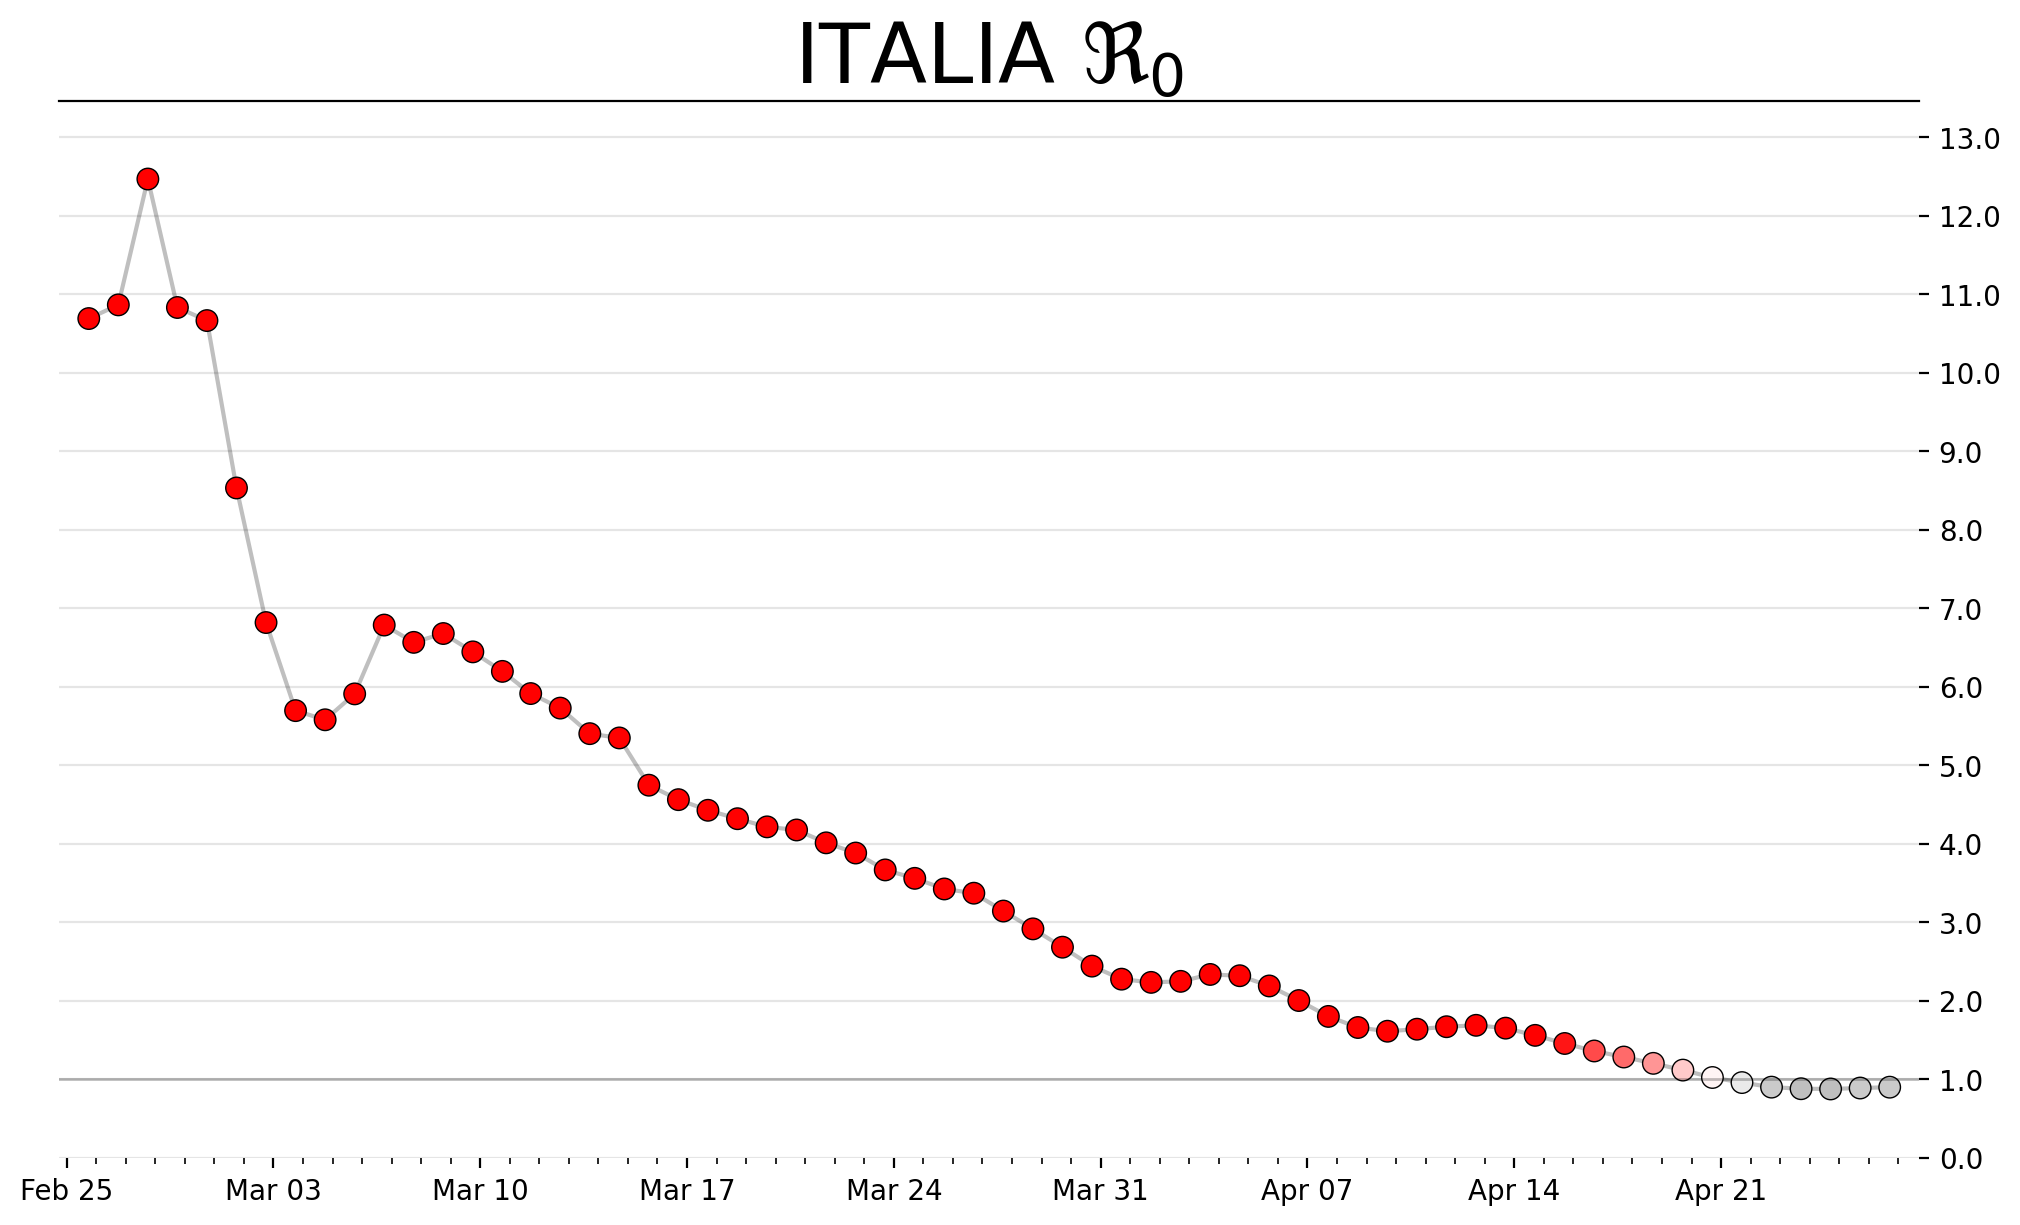

In [8]:
plot_r0(R0, "ITALIA")

Ricordiamo che, come detto in precedenza, nel caso di calcolo di $\Re_0$ dinamico il suo significato non è più quello del numero di riproduzione di base, ovvero del numero di soggetti contagiati mediamente da un infetto, ma solo di un valore soglia: quando $\Re_0$ è minore di $1$ l'epidemia è sotto controllo.

Notiamo che dal 21 Aprile $\Re_0 < 1$ dunque ci sono buone probabilità che l'epidemia di COVID-19 sia in via di estinzione. Ma vediamo anche però che è "intorno a 1" il che indica che le misure di contenimento non possono essere abbandonate troppo velocemente: l'abbattimento di $\Re_0$ in questo caso dipende proprio dall'effetto positivo delle contromisure adottate.

In [9]:
print(R0.tail(10))

                           R0
data                         
2020-04-17 17:00:00  1.281164
2020-04-18 17:00:00  1.200606
2020-04-19 17:00:00  1.114617
2020-04-20 17:00:00  1.020266
2020-04-21 17:00:00  0.955652
2020-04-22 17:00:00  0.897395
2020-04-23 17:00:00  0.877171
2020-04-24 17:00:00  0.874121
2020-04-25 17:00:00  0.886059
2020-04-26 17:00:00  0.896871


### $\Re_t$

Come si accennava, per il calcolo di $\Re_t$ la popolazione non deve essere eccessivamente ampia. L'intera popolazione italiana è troppo numerosa per una stima efficace di $\Re_t$ ma si può stimare il suo valore nel tempo per regione.

Anche in questo caso, i modelli e gli strumenti matematici di calcolo sono numerosi e molto complessi. Mostriamo qui il risultato di un calcolo _Bayesiano_ dinamico nel tempo $t$ basato sulla variazione giornaliera di nuovi contagi <cite data-cite="k-sys"></cite> <cite data-cite="bettencourt_ribeiro_2008"></cite>.

In [10]:
regioni = None
url_regioni = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv'
regioni = pd.read_csv(url_regioni,
                     usecols=['data', 'denominazione_regione', 'totale_casi'],
                     parse_dates=['data'],
                     index_col=['denominazione_regione', 'data'],
                     squeeze=True).sort_index()

# We create an array for every possible value of Rt
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

# Gamma is 1/serial interval
# https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article
# https://www.nejm.org/doi/full/10.1056/NEJMoa2001316
GAMMA = 1/7.5

def prepare_cases(cases, cutoff=1, std=2):

    new_cases = cases.diff()
    new_cases[new_cases < 0] = 0

    smoothed = new_cases.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=std).round()
    
    idx_start = np.searchsorted(smoothed, cutoff)
    
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

def highest_density_interval(pmf, p=.9):
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    
    # N x N matrix of total probability mass for each low, high
    total_p = cumsum - cumsum[:, None]
    
    # Return all indices with total_p > p
    lows, highs = (total_p > p).nonzero()
    
    try:
        # Find the smallest range (highest density)
        best = (highs - lows).argmin()
    except Exception as e:
        print("ERR {}".format(e))
        best = 0
    
    low = pmf.index[lows[best]]
    high = pmf.index[highs[best]]
    
    return pd.Series([low, high],
                     index=[f'Low_{p*100:.0f}',
                            f'High_{p*100:.0f}'])

def get_posteriors(sr, sigma=0.15):

    # (1) Calculate Lambda
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    
    # (2) Calculate each day's likelihood
    likelihoods = pd.DataFrame(
        data = sps.poisson.pmf(sr[1:].values, lam),
        index = r_t_range,
        columns = sr.index[1:])
    
    # (3) Create the Gaussian Matrix
    process_matrix = sps.norm(loc=r_t_range,
                              scale=sigma
                             ).pdf(r_t_range[:, None]) 

    # (3a) Normalize all rows to sum to 1
    process_matrix /= process_matrix.sum(axis=0)
    
    # (4) Calculate the initial prior
    prior0 = sps.gamma(a=4).pdf(r_t_range)
    prior0 /= prior0.sum()

    # Create a DataFrame that will hold our posteriors for each day
    # Insert our prior as the first posterior.
    posteriors = pd.DataFrame(
        index=r_t_range,
        columns=sr.index,
        data={sr.index[0]: prior0}
    )
    
    # We said we'd keep track of the sum of the log of the probability
    # of the data for maximum likelihood calculation.
    log_likelihood = 0.0

    # (5) Iteratively apply Bayes' rule
    for previous_day, current_day in zip(sr.index[:-1], sr.index[1:]):

        #(5a) Calculate the new prior
        current_prior = process_matrix @ posteriors[previous_day]
        
        #(5b) Calculate the numerator of Bayes' Rule: P(k|R_t)P(R_t)
        numerator = likelihoods[current_day] * current_prior
        
        #(5c) Calcluate the denominator of Bayes' Rule P(k)
        denominator = np.sum(numerator)
        
        # Execute full Bayes' Rule
        posteriors[current_day] = numerator/denominator
        
        # Add to the running sum of log likelihoods
        log_likelihood += np.log(denominator)
    
    return posteriors, log_likelihood


def plot_rt(result, ax, state_name):
    
    ax.set_title(f"{state_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('data')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low_90'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High_90'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-02-24'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 5.0)
    ax.set_xlim(pd.Timestamp('2020-02-24'), result.index.get_level_values('data')[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')


sigmas = np.linspace(1/20, 1, 20)

# targets = ~regioni.index.get_level_values('denominazione_regione')
# regioni_to_process = regioni.loc[regioni]

results = {}

for state_name, cases in regioni.groupby(level='denominazione_regione'):
    
    smoothed = []
    cutoff = 20
    while not len(smoothed):
        new, smoothed = prepare_cases(cases, cutoff=cutoff)
        cutoff -= 1
    
    result = {}
    
    # Holds all posteriors with every given value of sigma
    result['posteriors'] = []
    
    # Holds the log likelihood across all k for each value of sigma
    result['log_likelihoods'] = []
    
    for sigma in sigmas:
        posteriors, log_likelihood = get_posteriors(smoothed, sigma=sigma)
        result['posteriors'].append(posteriors)
        result['log_likelihoods'].append(log_likelihood)
    
    # Store all results keyed off of state name
    results[state_name] = result
    # clear_output(wait=True)

# Each index of this array holds the total of the log likelihoods for
# the corresponding index of the sigmas array.
total_log_likelihoods = np.zeros_like(sigmas)

# Loop through each state's results and add the log likelihoods to the running total.
for state_name, result in results.items():
    total_log_likelihoods += result['log_likelihoods']

# Select the index with the largest log likelihood total
max_likelihood_index = total_log_likelihoods.argmax()

# Select the value that has the highest log likelihood
sigma = sigmas[max_likelihood_index]

results = None

for name, cases in regioni.groupby(level='denominazione_regione'):
    
    original, smoothed = prepare_cases(cases, std=2)

    # Note that we're fixing sigma to a value just for the example
    posteriors, log_likelihood = get_posteriors(smoothed, sigma=sigma)

    # Note that this takes a while to execute - it's not the most efficient algorithm
    hdis = highest_density_interval(posteriors, p=.9)

    most_likely = posteriors.idxmax().rename('ML')

    # Look into why you shift -1
    result = pd.concat([most_likely, hdis], axis=1)
    results = pd.concat([results, result])

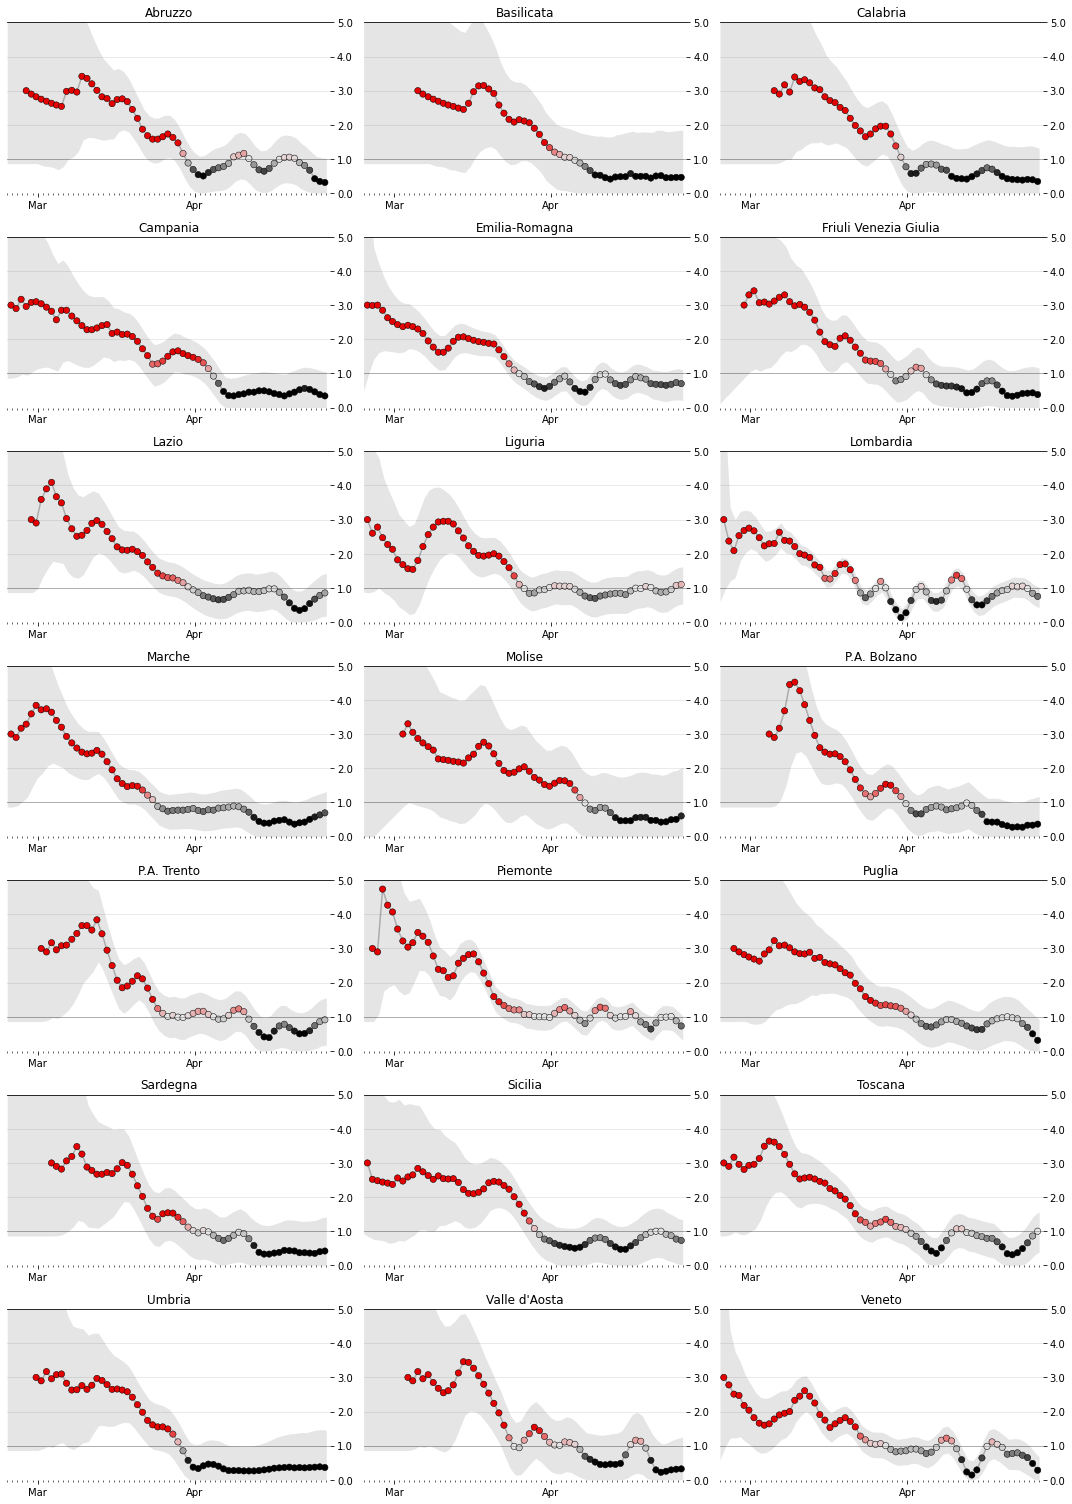

In [11]:
ncols = 3
nrows = 7

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

for i, (regione, result) in enumerate(results.groupby('denominazione_regione')):
    plot_rt(result, axes.flat[i], regione)

fig.tight_layout()
fig.set_facecolor('w')

Come dicevamo, $\Re_t$ varia anche in assenza di variazioni di $\Re_0$, ovvero in assenza di interventi contenitivi (o medici) e/o della loro efficacia. Grazie quindi alla stima di $\Re_t$ regionale possiamo tentare una prima "grezza" analisi e stimare il numero di riproduzione di base di COVID-19 in Italia al tempo $t_0$ facendo una media di $\Re_t$ regionale entro i primi giorni e prima dell'11 Marzo 2020, giorno del primo lockdown. Successivamente effettuare una media degli $\Re_0$ regionali e ottenere così un valore medio nazionale.

In [12]:
regioni_date = []
for i, (regione, result) in enumerate(results.groupby('denominazione_regione')):
    primo = result["ML"].index.get_level_values('data')[0]
    regioni_date.append([
        regione,
        primo,
    ])
regioni_date_df = pd.DataFrame(regioni_date, columns=["REGIONE", "primi casi confermati"])
regioni_date_df.set_index("REGIONE", inplace=True, drop=True)

print(regioni_date_df)

regioni_date_min = max(regioni_date_df["primi casi confermati"])
giorni_delta = (pd.Timestamp("2020-03-11 17:00:00") - regioni_date_min).days + 1

display(
    Markdown(
        "Dunque il primo giorno comune in cui tutte le regioni italiane hanno almeno un caso confermato di contagio è il {}.".format(
            regioni_date_min.strftime("%d %B %Y")
        )
    )
)

primi = []
for i, (regione, result) in enumerate(results.groupby('denominazione_regione')):
    primi.append([
        regione,
        regioni_date_min,
        regioni[regione][regioni_date_min]
    ])
primi_df = pd.DataFrame(primi, columns=["REGIONE", "data", "casi"])
primi_df.set_index("REGIONE", inplace=True, drop=True)

print(primi_df)

display(
    Markdown(
        "Il minimo lasso temporale utilizzabile è dunque di {} giorni (differenza tra il {} e l'11 Marzo 2020).".format(
            giorni_delta,
            regioni_date_min.strftime("%d %B %Y")
        )
    )
)

display(
    Markdown(
        "Questo ci da la possibilità di effettuare una media degli $\Re_0$ regionali dei primi {} giorni di contagi confermati in ciascuna regione.".format(
            giorni_delta
        )
    )
)

                      primi casi confermati
REGIONE                                    
Abruzzo                 2020-02-27 18:00:00
Basilicata              2020-03-05 17:00:00
Calabria                2020-03-05 17:00:00
Campania                2020-02-24 18:00:00
Emilia-Romagna          2020-02-24 18:00:00
Friuli Venezia Giulia   2020-02-28 18:00:00
Lazio                   2020-02-28 18:00:00
Liguria                 2020-02-24 18:00:00
Lombardia               2020-02-24 18:00:00
Marche                  2020-02-24 18:00:00
Molise                  2020-03-02 18:00:00
P.A. Bolzano            2020-03-04 17:00:00
P.A. Trento             2020-03-01 17:00:00
Piemonte                2020-02-25 18:00:00
Puglia                  2020-02-26 18:00:00
Sardegna                2020-03-03 18:00:00
Sicilia                 2020-02-24 18:00:00
Toscana                 2020-02-24 18:00:00
Umbria                  2020-02-29 17:00:00
Valle d'Aosta           2020-03-03 18:00:00
Veneto                  2020-02-

Dunque il primo giorno comune in cui tutte le regioni italiane hanno almeno un caso confermato di contagio è il 05 Marzo 2020.

                                     data  casi
REGIONE                                        
Abruzzo               2020-03-05 17:00:00     8
Basilicata            2020-03-05 17:00:00     1
Calabria              2020-03-05 17:00:00     2
Campania              2020-03-05 17:00:00    45
Emilia-Romagna        2020-03-05 17:00:00   698
Friuli Venezia Giulia 2020-03-05 17:00:00    21
Lazio                 2020-03-05 17:00:00    44
Liguria               2020-03-05 17:00:00    28
Lombardia             2020-03-05 17:00:00  2251
Marche                2020-03-05 17:00:00   124
Molise                2020-03-05 17:00:00     7
P.A. Bolzano          2020-03-05 17:00:00     1
P.A. Trento           2020-03-05 17:00:00     7
Piemonte              2020-03-05 17:00:00   108
Puglia                2020-03-05 17:00:00    14
Sardegna              2020-03-05 17:00:00     2
Sicilia               2020-03-05 17:00:00    18
Toscana               2020-03-05 17:00:00    61
Umbria                2020-03-05 17:00:0

Il minimo lasso temporale utilizzabile è dunque di 7 giorni (differenza tra il 05 Marzo 2020 e l'11 Marzo 2020).

Questo ci da la possibilità di effettuare una media degli $\Re_0$ regionali dei primi 7 giorni di contagi confermati in ciascuna regione.

In [13]:
R0s = []
R0sdf = None
for i, (regione, result) in enumerate(results.groupby('denominazione_regione')):
    R0s.append([
        regione,
        np.mean(result["ML"].head(giorni_delta).values),
        result["ML"].head(giorni_delta).index.get_level_values('data')[0].strftime("%d %b %Y"),
        result["ML"].head(giorni_delta).index.get_level_values('data')[-1].strftime("%d %b %Y")
    ])
R0sdf = pd.DataFrame(R0s, columns=[
    "REGIONE",
    f"R0 medio",
    "INIZIO",
    "FINE"
])
R0sdf.set_index("REGIONE", inplace=True, drop=True)
print(R0sdf)
R0IT = np.median(R0sdf[f"R0 medio"].values)
R0ITmin = min(R0sdf[f"R0 medio"].values)
R0ITmax = max(R0sdf[f"R0 medio"].values)

display(
    Markdown(
        f"Da cui possiamo ricavare che $\Re_0$ medio italiano per COVID-19 nelle prime fasi dell'epidemia potrebbe essere pari a ${R0IT:.2f}$ (${R0ITmin:.2f}$-${R0ITmax:.2f}$)."
    )
)

                       R0 medio       INIZIO         FINE
REGIONE                                                  
Abruzzo                2.767143  27 Feb 2020  04 Mar 2020
Basilicata             2.767143  05 Mar 2020  11 Mar 2020
Calabria               3.145714  05 Mar 2020  11 Mar 2020
Campania               3.035714  24 Feb 2020  01 Mar 2020
Emilia-Romagna         2.774286  24 Feb 2020  01 Mar 2020
Friuli Venezia Giulia  3.147143  28 Feb 2020  05 Mar 2020
Lazio                  3.520000  28 Feb 2020  05 Mar 2020
Liguria                2.438571  24 Feb 2020  01 Mar 2020
Lombardia              2.584286  24 Feb 2020  01 Mar 2020
Marche                 3.357143  24 Feb 2020  01 Mar 2020
Molise                 2.874286  02 Mar 2020  08 Mar 2020
P.A. Bolzano           3.712857  04 Mar 2020  10 Mar 2020
P.A. Trento            3.068571  01 Mar 2020  07 Mar 2020
Piemonte               3.681429  25 Feb 2020  02 Mar 2020
Puglia                 2.804286  26 Feb 2020  03 Mar 2020
Sardegna      

Da cui possiamo ricavare che $\Re_0$ medio italiano per COVID-19 nelle prime fasi dell'epidemia potrebbe essere pari a $2.96$ ($2.40$-$3.71$).

***